# Cluster-cross-validation

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.neighbors import DistanceMetric
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from random import shuffle
import clustercv

from rdkit.Chem import MolFromSmiles
from rdkit.Chem.Descriptors import ExactMolWt
from rdkit.Chem.AllChem import GetMorganFingerprintAsBitVect

Read data file:

In [2]:
data = pd.read_csv("cmpd_activity_tcrd_5.4.1.csv", low_memory=False)
data.shape

(382291, 11)

## Data Filtering

We take only assays with IC50 data, and whose targets have more than 100 ligands.

In [3]:
targets = clustercv.filter_data(data, act_type='IC50', min_samples=100)
print("Number of targets:", len(targets))

Number of targets: 390


## Get Features

In [4]:
targets.index(5857)

140

In [5]:
# Select a target
n = targets[1]
target_data = clustercv.get_target_data(data, n)

192553    COc1cc(\C=C\c2cccc(\C=C\c3ccc(N(C)C)c(OC)c3)c2...
192554      COc1ccc2C=C(C(=O)CN3CCN(CC3)c4ncccn4)C(=O)Oc2c1
192555    Clc1ccc(cc1)S(=O)(=O)N2C(CCOC(=O)N3CCN(CC3)C4C...
192556    FC(F)(F)c1ccc(cc1)C(=O)Nc2ccc3C[C@@H]4CC[C@H](...
192557    CO[C@@H]1CC[C@@]2(CC1)Cc3cc(F)c(cc3[C@]24N=C(C...
192559                      Nc1nc(NCc2ccc(Cl)cc2)nc3ccccc13
192561    CN(C)c1ccc(\C=C\c2cccc(\C=C\c3ccc(N(C)C)c(O)c3...
192562     CNc1ccc(\C=C\c2cccc(\C=C\c3ccc(NC)c(O)c3)n2)cc1O
192563    COc1ccc(\C=C\c2cccc(\C=C\c3ccc(OC)c(c3)N(C)C)n...
192564    Clc1ccc(cc1)S(=O)(=O)N2C(CCOC(=O)NC3CCN(Cc4ccc...
192567              [O-][N+](=O)c1cc(Cl)ccc1NC(=O)Nc2ccccc2
192568    OCCN1CCN(CC1)C(=O)OCCC2CCc3ccccc3N2S(=O)(=O)c4...
192573                    COc1ccc2oc(\C=C\c3ccc(N)cc3)cc2c1
192574                COc1ccc2oc(\C=C\c3ccc(cc3)N(C)C)cc2c1
192576                   CNc1ccc(\C=C\c2oc3cc(OC)ccc3c2)cc1
192577    COc1cc(\C=C\C(=C\C(=O)\C=C\c2ccc(O)c(OC)c2)\O)...
192578    COc1cc(\C=C\C(=C\C(=O)\C=C\c2c

AttributeError: 'numpy.ndarray' object has no attribute 'isna'

In [82]:
# Filter by molecules that can be converted by rdkit
mols = target_data.smiles.apply(lambda x: MolFromSmiles(x))
target_data = target_data[[not m for m in mols.isna()]]
# Filter by weight
weights = target_data.smiles.apply(lambda x: ExactMolWt(MolFromSmiles(x)))
target_data = target_data[(weights >= 100) & (weights <= 600)]

In [84]:
# Get fingerprints for all the ligands in the target
features = clustercv.batchECFP(target_data.smiles)

## Get Distance Matrix

In [85]:
dist = DistanceMetric.get_metric('jaccard')
distmatrix = dist.pairwise(features)

## Agglomerative Clustering

In [93]:
# Find the number of clusters that maximizes the Silhouette score
linkage = 'complete'
n_folds = 10

num_samples = len(target_data)
scores = np.zeros(num_samples)
for i in range(n_folds * 2, num_samples):
    clustering = AgglomerativeClustering(n_clusters=i, affinity='precomputed', linkage=linkage)
    clustering = clustering.fit(distmatrix)
    scores[i] = (silhouette_score(distmatrix, labels=clustering.labels_, metric="precomputed"))

max_score = max(scores)
n_clusters = np.where(scores == max(scores))[0][0]
print("Max score:", max_score)
print("Num clusters:", n_clusters)

Max score: 0.318606508774
Num clusters: 58


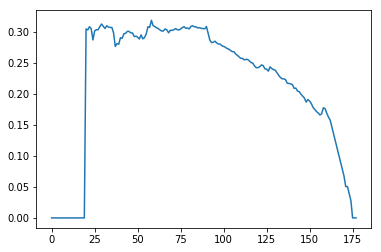

In [94]:
plt.plot(scores)
plt.show()

In [95]:
clustering = AgglomerativeClustering(n_clusters=n_clusters, affinity='precomputed', linkage=linkage)
clustering = clustering.fit(distmatrix)

score = silhouette_score(distmatrix, labels=clustering.labels_, metric="precomputed")
print("Silhouette score:", score)

y = np.bincount(clustering.labels_)
for i, _ in enumerate(y):
    print("Cluster{} size: {}".format(i, y[i]))

Silhouette score: 0.318606508774
Cluster0 size: 11
Cluster1 size: 2
Cluster2 size: 13
Cluster3 size: 2
Cluster4 size: 13
Cluster5 size: 4
Cluster6 size: 3
Cluster7 size: 3
Cluster8 size: 4
Cluster9 size: 2
Cluster10 size: 2
Cluster11 size: 5
Cluster12 size: 6
Cluster13 size: 5
Cluster14 size: 3
Cluster15 size: 5
Cluster16 size: 8
Cluster17 size: 5
Cluster18 size: 2
Cluster19 size: 1
Cluster20 size: 3
Cluster21 size: 2
Cluster22 size: 1
Cluster23 size: 14
Cluster24 size: 2
Cluster25 size: 8
Cluster26 size: 2
Cluster27 size: 3
Cluster28 size: 5
Cluster29 size: 1
Cluster30 size: 1
Cluster31 size: 1
Cluster32 size: 2
Cluster33 size: 2
Cluster34 size: 1
Cluster35 size: 2
Cluster36 size: 1
Cluster37 size: 2
Cluster38 size: 1
Cluster39 size: 1
Cluster40 size: 1
Cluster41 size: 1
Cluster42 size: 1
Cluster43 size: 1
Cluster44 size: 1
Cluster45 size: 1
Cluster46 size: 1
Cluster47 size: 1
Cluster48 size: 1
Cluster49 size: 1
Cluster50 size: 1
Cluster51 size: 4
Cluster52 size: 1
Cluster53 size: 1
C

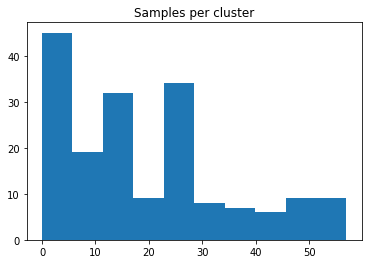

In [96]:
plt.hist(clustering.labels_)
plt.title("Samples per cluster")
plt.show()

## Cross Validation

In [97]:
# Randomly assign each cluster to one fold
cluster_nums = list(range(n_clusters))
shuffle(cluster_nums)
fold_assignments = {}
for n in range(n_clusters):
    fold_assignments[cluster_nums[n]] = n % n_folds
# Assign samples to folds
folds = np.zeros(num_samples)
for j in range(num_samples):
    folds[j] = fold_assignments[clustering.labels_[j]]

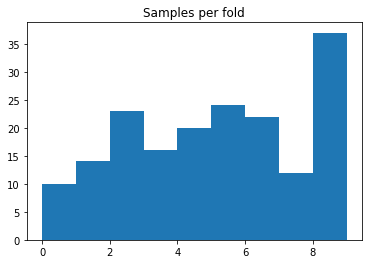

In [98]:
plt.hist(folds, bins= n_folds-1)
plt.title("Samples per fold")
plt.show()

In [99]:
n_features = features.shape[1]

for k in range (n_folds):
    # Get training and testing set
    test_index = np.where(folds == k)[0]
    train_index = np.where(folds != k)[0]
    # Get train and test samples
    X_test = features[test_index, :]
    X_train = features[train_index, :]
    print("test:", X_test.shape[0], "\ttrain:", X_train.shape[0])

test: 10 	train: 168
test: 14 	train: 164
test: 23 	train: 155
test: 16 	train: 162
test: 20 	train: 158
test: 24 	train: 154
test: 22 	train: 156
test: 12 	train: 166
test: 24 	train: 154
test: 13 	train: 165
